# Getting started

Below we introduce the basics of GRANAD and perform an example simulation.

## Introduction

GRANAD lets you simulate structures from a few orbitals up to extended nanostructures. The process of specifying a structure is designed to be easy and interactive: You can add, shift, combine and manipulate parts of your structure at varying levels of detail involving large groups of orbitals or single orbitals. To this end, GRANAD offers three fundamental datatypes:

1. *Orbitals* are the fundamental building block of a structure.
2. *Materials* are a stand-in for infinite bulks. You can cut finite pieces from these bulks, which correspond to lists of orbitals with specified positions and properties.
3. *OrbitalLists* represent a concrete structure. In essence, you can handle these as normal Python lists with additional information regarding Orbital coupling.

We will use each of them below to set up a small graphene nanoflake coupling to an external electric field.

Once this is done, we will use GRANAD's main feature and simulate the induced dynamics in the nanoflake directly in time domain.

## Orbitals

Here, we create an orbital and print its properties to understand its structure. By default, each orbital is considered to be occupied by 1 electron.


In [1]:
from granad import Orbital

my_first_orbital = Orbital(
    tag = "a tag contains arbitrary information",
)
print(my_first_orbital)

{'position': Array([0., 0., 0.], dtype=float64),
 'layer_index': None,
 'tag': 'a tag contains arbitrary information',
 'spin': None,
 'atom_name': None,
 'group_id': GroupId(id=1)}


From the output above, we see that orbitals are characterized by their position and a user-defined tag. They are placed at the origin by default. We can change this by passing an explicit position.

In [2]:

my_second_orbital = Orbital(
    position = (1, 1, 1),
    tag = "a new, shifted orbital",
)
print(my_second_orbital)


{'position': Array([1., 1., 1.], dtype=float64),
 'layer_index': None,
 'tag': 'a new, shifted orbital',
 'spin': None,
 'atom_name': None,
 'group_id': GroupId(id=2)}



## Materials

Materials can be used to create orbital lists. Users can define custom materials or choose among the prebuilt options. Prebuilt materials correspond to fixed models common in the literature. In modelling electronic interactions, GRANAD supports hoppings and Coulomb interactions. The built-in graphene model contains only a single pz orbital per atom. Materials are obtained through the MaterialCatalog

In [3]:
from granad import MaterialCatalog
MaterialCatalog.available()

Available materials:
graphene
ssh
chain
hBN


Let's inspect a material.

In [4]:
MaterialCatalog.describe("graphene")

Material: graphene
  Lattice Constant: 2.46 Å
  Lattice Basis: 
[[ 1.         0.         0.       ]
 [-0.5        0.8660254  0.       ]]
  Orbital Species:
    pz characterized by (n,l,m,s, atom name) = (0, 'C')
  Orbitals:
    Position: (0, 0), Tag: sublattice_1, Species: pz
    Position: (-0.3333333333333333, -0.6666666666666666), Tag: sublattice_2, Species: pz
  Interactions:
   Type: hamiltonian, Participants: ('pz', 'pz'):
                    NN Couplings: 0, -2.66
                    Other neighbors: 
    Returns a zero coupling constant as a complex number.

    Args:
        d (float): A parameter (typically representing distance or some other factor) that is ignored by the function, as the output is always zero.

    Returns:
        complex: Returns 0.0 as a complex number (0.0j).
    
   Type: coulomb, Participants: ('pz', 'pz'):
                    NN Couplings: 16.522, 8.64, 5.333
                    Other neighbors: Coupling with a (regularized) Coulomb-like potential



This function prints a description of the material, i.e., its parameters, geometry, the type of the involved orbitals, the position of orbitals in the unit cell and the interactions. Let's pick a concrete material.

In [5]:
graphene = MaterialCatalog.get("graphene")

NOTE: The MaterialCatalog provides pre-defined materials with default values for quick access. These materials can be customized at the time of retrieval by passing parameters directly to the `get` method. For example, to create and customize an SSH model with specific hopping parameters and atomic displacement:

In [6]:
my_ssh_model = MaterialCatalog.get("ssh", delta = 0.1, displacement = 0.6)
my_ssh_chain = my_ssh_model.cut_flake(10)  

## OrbitalLists

An OrbitalList is a list of orbitals. They can be created directly by combining user-defined orbitals

In [7]:
from granad import OrbitalList

my_first_orbital_list = OrbitalList([my_first_orbital, my_second_orbital])
print(my_first_orbital_list)

List with 2 orbitals, 2 electrons.
Excitation: [0] electrons excited from energy levels [0] to [0].
Included tags with number of orbitals: {'a tag contains arbitrary information': 1, 'a new, shifted orbital': 1}


This displays information about the number of orbitals, electrons and single-particle excitations involved in constructing the initial density matrix.

Alternatively, orbital lists can represent flakes cut from a material. You do this by specifying the shape of the flake.
You can specify an arbitrary shape, but this is covered in a separate tutorial.
For now, we will use a built-in shape: an triangle with a base length of 18 Angström.

In [8]:
from granad import Triangle
import jax.numpy as jnp
triangle = Triangle(18)

Now, our shape is ready and we can start cutting. To make sure that we are satisfied with what we get, we plot the flake. By default, GRANAD cuts any "dangling" atoms.

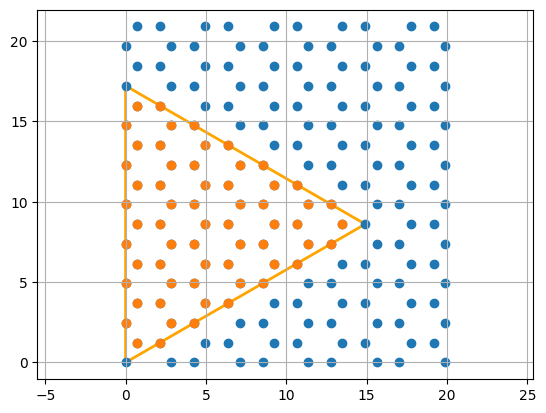

List with 61 orbitals, 61 electrons.
Excitation: [0] electrons excited from energy levels [0] to [0].
Included tags with number of orbitals: {'sublattice_1': 28, 'sublattice_2': 33}


In [9]:
my_first_flake = graphene.cut_flake(triangle, plot = True)
print(my_first_flake)

Note that the `plot=True` option displays an "infinite" graphene sheet (blue points), from which only the flake (orange points) will be kept in the final structure. If you want to visualize the flake in isolation, use `show_2d`, as explained in more detail in the plotting tutorial.

There is an extra option for dealing with graphene-like lattices we can pass to the built-in shape, which is the armchair boolean. It rotates the shape to get the correct edge type. The optional "shift" argument lets you shift the shape in the plane.

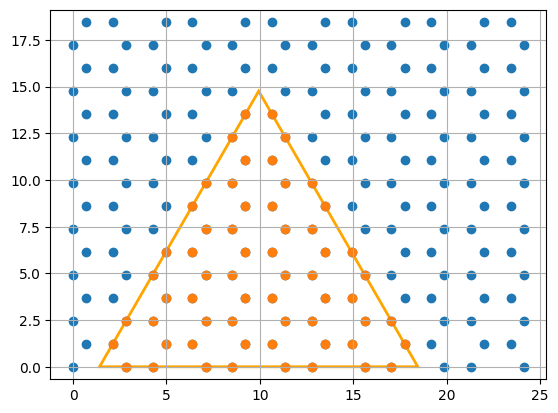

In [10]:
triangle_ac = Triangle(18, armchair = True)
my_first_flake = graphene.cut_flake(triangle_ac, plot = True)

For more information on cutting, including different edge types and how to keep dangling atoms, have a look at the corresponding tutorial.

## A first simulation

GRANAD offers access to the time-resolved density matrix $\rho(t)$ of a system by integrating a nonlinear master equation. The exact mathematical details are covered in the tutorial on time-domain simulations. Once the time dependent density matrix is known, dynamical expectation values can be computed. For a Hermitian operator $A$, the expectation value is then  $a(t) = \text{Tr}[\rho(t) A]$. We will illustrate this with the example of the dipole moment in the small graphene flake we created above.

The density matrix is normalized to allow two electrons per single-particle energy eigenstate and populated according to the Aufbau principle. The energy landscape together with the initial state occupation can be visualized as follows

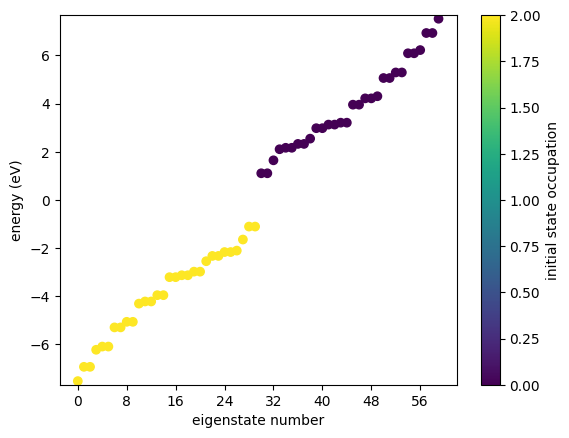

In [11]:
my_first_flake.show_energies()

GRANAD offers similar built-in functions to visualize static and dynamic properties of a flake. For more information, please consult the corresponding tutorial.

Now that we are ready, we can study the induced dipole moment. In particular, we will:

1. Excite the flake with an electric field.
2. Compute its dipole moment $\vec{p}(t) = \text{Tr}[\rho(t) \vec{P}]$, where $\vec{P}$ is the dipole operator.

The electric field is given as a function mapping the time (a single float) to a vector representing the field components like this `field : t -> vec`.

In addition to GRANAD's built-in functions, custom functions for illumination can be specified. We will use the built-in Pulse.

In [12]:
from granad import Pulse

my_first_illumination = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=2.3, peak=5, fwhm=2
)
print( my_first_illumination( 0.0) ) # initial field

[2.60905079e-13 0.00000000e+00 0.00000000e+00]


The pulse corresponds to a plane wave with a Gaussian temporal profile. To visualize it, please consult the electric fields tutorial.

Now we come to the actual simulation. For any time-domain simulation, we have to decide on a few additional parameters:

1. Simulation duration: here, we set the duration from 0 to 40 units.
2. Relaxation rate: here, we pick a single number characterizing the rate of energy dissipation across all channels.
3. The operators whose expectation values we want to compute. They are given as a list.

We want to calculate the induced polarization from the dipole operator. This operator can be represented as a 3xNxN matrix, where N is the number of orbitals and 3 corresponds to Cartesian components x,y,z and we can compute it directly

In [13]:
print(my_first_flake.dipole_operator.shape)

(3, 60, 60)


We want to compute its expectation value, so we have to wrap it in a list and pass it to the time-domain simulation, called `master_equation`

In [14]:
result = my_first_flake.master_equation(
    end_time=40, # the start is set to 0 by default 
    relaxation_rate=1 / 10,
    illumination=my_first_illumination,
    expectation_values = [my_first_flake.dipole_operator] # you can also omit the brackets for a single operator, but this is bad practice
    )

RHS compiled
RHS compiled


100.0 %


If you want to compute expectaion values of more operators, you can add them to the list.

The result variable is a container for 

1. the last density matrix in the simulation, which is important if you want to continue the time evolution.
2. the time axis, which is an array of samples [t_1, t_2, ... t_n].
3. an "output", which is a list of arrays, corresponding to the operators we passed in. Each array contains the time-dependent expectation value like [p_1, p_2, ..., p_n].

We have specified one operator to compute the expectation value of, such that the list only contains one element.

In [15]:
print(len(result.output))

1


This list contains an array of shape Tx3, where T is the number of saved time steps. So,  the dipole moment at the 10-th timestep in x-direction is obtained by

In [16]:
dipole_moments = result.output[0]
print(dipole_moments[10, 0])

(4.013523589402245e-13+0j)


Now that we understand how a time domain simulation works, we can visualize the result. GRANAD offers a dedicated function for this

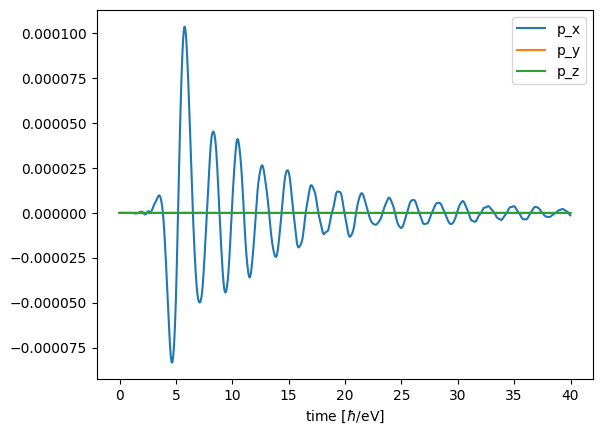

In [17]:
my_first_flake.show_res(result, plot_labels = ["p_x", "p_y", "p_z"]) 

To visualize the field

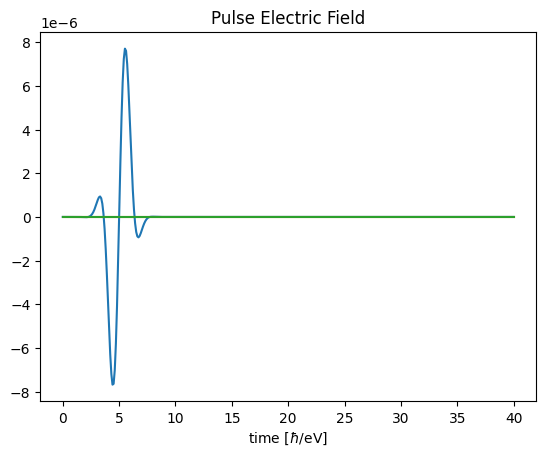

In [18]:
import jax
import matplotlib.pyplot as plt
time = jnp.linspace(0, 40, 400)
e_field = jax.vmap(my_first_illumination)(time)
plt.plot(time, e_field)
plt.title("Pulse Electric Field")
plt.xlabel(r"time [$\hbar$/eV]")
plt.show()